<footer id="footer"></footer>

# Определение возраста покупателей

![](https://i.ibb.co/GdM2Tk8/how-to-write-a-cv-1.png)

**Сетевой супермаркет** внедряет систему **компьютерного зрения для обработки фотографий покупателей**. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  


- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  

- контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

<a href="#footer">В начало</a>
<footer id="footer"></footer>

___

# Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set_style ('darkgrid')
%matplotlib inline
np.random.seed(42)

___

Загрузим имеющийся сет с метками

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
labels.head(10).style.set_caption('Информация по меткам')

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


Сет содержит информацию о названии файла и реальном возрасте объекта

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Пропусков нет, распределение скошено направо, ассиметрично-положительно. Среднее значение больше медианы, наблюдается длинный хвост, максимальный возраст - 100 лет: данная категория людей относится к долгожителям и не является часто встречающейся - это может сказаться на точности определения данной [возрастной группы](https://ru.wikipedia.org/wiki/%D0%92%D0%BE%D0%B7%D1%80%D0%B0%D1%81%D1%82%D0%BD%D0%B0%D1%8F_%D0%BF%D0%B5%D1%80%D0%B8%D0%BE%D0%B4%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)

In [ ]:

labels['real_age'].loc[labels['real_age'] >= 90].value_counts().to_frame()

,real_age
90,21
94,5
96,2
95,2
100,1
97,1
93,1
91,1


Как мы видим, количество людей старше 90 лет встречается в сете достаточно редко. Высокая точность должна наблюдаться на образцах возрастом 20-41 год, на других возрастных группах - возможно увеличение ошибки. Метрику возьмем MAE - она наиболее робастная по отношению к выбросам и лучше интерпритируется. При построении модели обязательно включим в последний слой функцию активации, чтобы не получить отрицательный возраст

In [ ]:
labels.shape

(7591, 2)

Загрузим фотоизображения. Использовать будем класс ImageDataGenerator, который будем использовать при обучении модели

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = (train_datagen.flow_from_dataframe(
                    dataframe=labels, directory='/datasets/faces/final_files/',
                    x_col='file_name', 
                    y_col='real_age', 
                    target_size=(224, 224), 
                    batch_size=32, 
                    class_mode='raw', 
                    seed=12345
    )
)

Found 7591 validated image filenames.


Построим графики распредления возрастов в сете

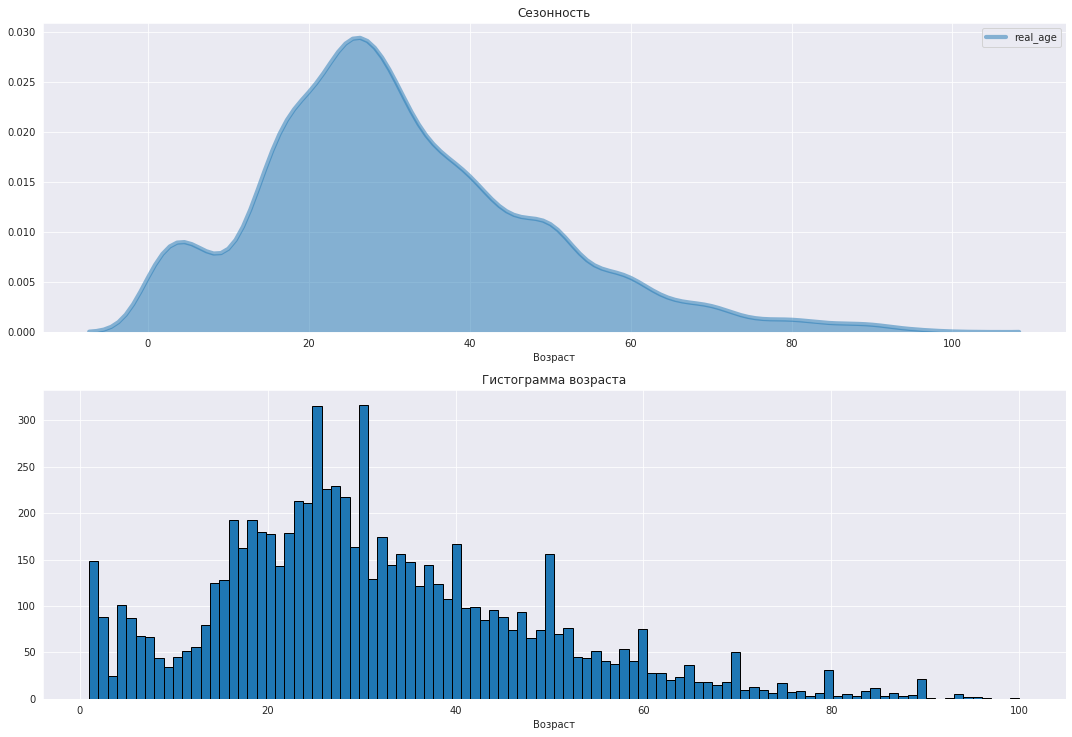

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(311)
sns.kdeplot(data=labels['real_age'], shade=True, 
                 alpha=.5, linewidth=4.2
)

plt.xlabel("Возраст")
plt.title('KDE оценка плотности')
plt.title('Сезонность')


plt.subplot(312)
labels['real_age'].hist(bins=100, ec='black')

plt.xlabel("Возраст")
plt.title('Гистограмма возраста')

plt.tight_layout()

Наши выводы подтверждаются - сет скошен, длинный хвост наблюдается из объектов старше 60 лет. Стоит отметить, что почти на всех круглых датах наблюдаются пики. Возможно это либо ошибка ассесора, либо при сборе данных (если проводили анкетирование) - возраст не был указан точно, а был назван примерный. Необходимо проработать дополнительно данные группы.  

Вероятно, что данные на этих точках искажены, что может сказаться на качестве модели

Посмотрим представленные фотографии - возьмем несколько проб из ImageDataGenerator:

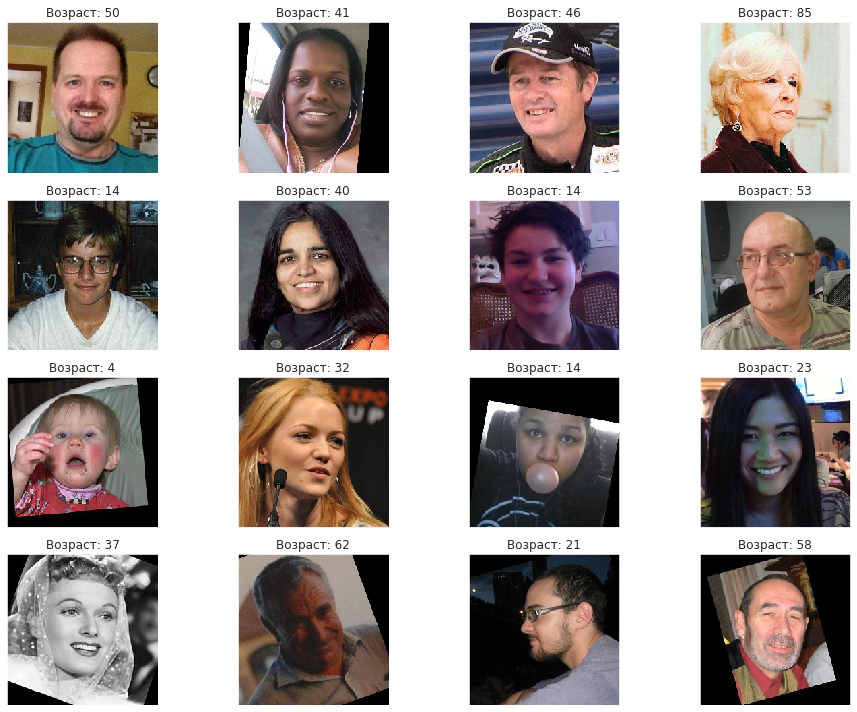

In [ ]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    
    plt.imshow(features[i])
    
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Возраст: ' + str(target[i]))

___

В сете представлены фотографии различных людей различных возрастных групп. У фотографий различается качество, есть черно-белые, есть цветные фотографии, некоторые фотографии уже повернуты, думаю, что аугментация здесь не потребуется, либо используем незначительные изменения в виде горизонтального отображения. Показаны различные эмоции, у некоторых людей есть аксессуары. Использовать будем архитектуру сети на базе ResNet, с весами ImageNet, костяк замораживать не будем

<a href="#footer">В начало</a>
<footer id="footer"></footer>

# Обучение модели

[Код](https://colab.research.google.com/drive/1ezIf1XzYZHxRVGHDeS5pnRImGgKXeeUt?usp=sharing) в этом разделе и вычисления производились на сервере с графической картой (GPU) [Yandex Compute Cloud](https://cloud.yandex.ru/services/compute)

---

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import numpy as np
import pandas as pd

# загрузка обучающей выборки

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1./255,
                          horizontal_flip=True
                          )
    train_datagen_flow = (train_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(150, 150), 
                          batch_size=8, 
                          class_mode='raw',
                          subset='training', 
                          seed=12345
                          )
    )
    
    return train_datagen_flow

# загрузка валидационной выборки

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
                          validation_split=0.25,
                          rescale=1./255
                          )
    test_datagen_flow = (test_datagen.flow_from_dataframe(
                          dataframe=labels, 
                          directory=path + 'final_files/',
                          x_col='file_name', 
                          y_col='real_age', 
                          target_size=(150, 150), 
                          batch_size=8, 
                          class_mode='raw',
                          subset='validation', 
                          seed=12345
                          )
    )
    
    return test_datagen_flow    

# Создание модели на архитектуре ResNet50

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer=Nadam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model

# Обучение модели

def train_model(model, train_data, test_data, epochs=8, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
  
    train_datagen_flow = train_data
    test_datagen_flow = test_data

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=(test_data), epochs=epochs,
              steps_per_epoch=steps_per_epoch, batch_size=batch_size,
              validation_steps=validation_steps, 
              verbose=2, shuffle=True)
    return model 

```

<span style="color:blue">
    
Using TensorFlow backend.   
Found 5694 validated image filenames.   
Found 1897 validated image filenames. 
</span>
    
***    



```
Train for 712 steps, validate for 238 steps

Epoch 1/8
712/712 - 68s - loss: 210.0549 - mae: 10.7467 - val_loss: 137.5606 - val_mae: 8.8254
Epoch 2/8
712/712 - 47s - loss: 97.5117 - mae: 7.5371 - val_loss: 97.7074 - val_mae: 7.4525
Epoch 3/8
712/712 - 47s - loss: 64.8461 - mae: 6.1348 - val_loss: 86.9212 - val_mae: 7.2401
Epoch 4/8
712/712 - 47s - loss: 46.2658 - mae: 5.2529 - val_loss: 79.0788 - val_mae: 6.7077
Epoch 5/8
712/712 - 47s - loss: 32.6799 - mae: 4.3943 - val_loss: 86.4948 - val_mae: 7.0620
Epoch 6/8
712/712 - 47s - loss: 28.3119 - mae: 4.0341 - val_loss: 89.7880 - val_mae: 6.9997
Epoch 7/8
712/712 - 47s - loss: 24.0599 - mae: 3.7065 - val_loss: 79.3755 - val_mae: 6.7442
Epoch 8/8
712/712 - 47s - loss: 20.0178 - mae: 3.4389 - val_loss: 71.0045 - val_mae: 6.3097  


238/238 - 9s - loss: 71.0045 - mae: 6.3097
Test MAE: 6.3097





___

<a href="#footer">В начало</a>
<footer id="footer"></footer>

# Анализ обученной модели

Построили модель, которая по фотографии определит приблизительный возраст человека с ошибкой **6.3 года**. Стоить отметить, что даже при небольшом количестве эпох наблюдается переобучение - мы видим значительное улучшение качества на обучающей выборке, при этом на валидационной выборке качество растет значительно медленнее. Данный факт связан со склонностью многослойных архитектур сетей к переобучению и не можем сигнализировать о плохом качестве модели, в данном случае - при необходимости, можно провести дополнительные тесты и понаблюдать, как модель обобщается

Возможно поэксперементировать с архитектурой сети, попробовать иные варианты, если данный результат не приемлем заказчику.   

Было поставлено две основные цели данного проекта:   

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- контролировать добросовестность кассиров при продаже алкоголя.  

По первому пункту ошибка допустима, по второму необходимо провести дополнительную проверку данных возрастных групп до 18 лет. 


<a href="#footer">В начало</a>
<footer id="footer"></footer>